In [1]:
import scipy as sp
from scipy import integrate
import numpy as np
import pylab
from pylab import rcParams
from IPython.display import clear_output
import seaborn as sns
import logging
from datetime import datetime
import os

In [2]:
rcParams['figure.figsize'] = 10, 10
np.set_printoptions(threshold=np.inf)

In [3]:
def G(u, v, p, q):
    return 1-u*v

def H(u, v, p, q):
    return p * v * (u - (1+q)/(q+v))


In [4]:
def Brusselator_reshape(y, t, p, q, Du, Dv, dx, dy, dim):
    y_buf = y.reshape((2,dim,dim))
    u = y_buf[0]
    v = y_buf[1]

    dydt = np.zeros_like(y)
    dydt_buf = dydt.reshape((2,dim,dim))
    
    dudt = dydt_buf[0]
    dudt += G(u,v,p,q)
    dvdt = dydt_buf[1]
    dvdt += H(u,v,p,q)

    #---------------------------------------------------------------------------

    dudt[:,1:-1] += Du * np.diff(u,2,axis = 1)  / dx**2
    dudt[1:-1,:] += Du * np.diff(u,2,axis = 0)  / dy**2

    dudt[0,:]  += Du * (-2.0*u[0,:] + 2.0*u[1,:]) / dy**2 
    dudt[-1,:]  += Du * (-2.0*u[-1,:] + 2.0*u[-2,:]) / dy**2 

    dudt[:,0]  += Du * (-2.0*u[:,0] + 2.0*u[:,1]) / dx**2 
    dudt[:,-1]  += Du * (-2.0*u[:,-1] + 2.0*u[:,-2]) / dx**2 

    #---------------------------------------------------------------------------

    dvdt[:,1:-1] += Dv * np.diff(v,2,axis = 1)  / dx**2
    dvdt[1:-1,:] += Dv * np.diff(v,2,axis = 0)  / dy**2

    dvdt[0,:]  += Dv * (-2.0*v[0,:] + 2.0*v[1,:]) / dy**2 
    dvdt[-1,:]  += Dv * (-2.0*v[-1,:] + 2.0*v[-2,:]) / dy**2 

    dvdt[:,0]  += Dv * (-2.0*v[:,0] + 2.0*v[:,1]) / dx**2 
    dvdt[:,-1]  += Dv * (-2.0*v[:,-1] + 2.0*v[:,-2]) / dx**2 
    return dydt

In [5]:
def Run(params_system, params_numerical, display_res = True, out_folder_suffix = None):
    p,q,Du,Dv,init_picks = params_system.values()
    points_count,dx,dy,dt,t_calc_batch,iters = params_numerical.values()
    
    x_right_border = int(points_count*dx)
    xs = np.linspace(0,x_right_border,points_count)

    y_right_border = int(points_count*dy)
    ys = np.linspace(0,y_right_border,points_count)
    
    t = np.arange(0, t_calc_batch, dt)
    
    if init_picks is None:
        y0 = np.random.randn(points_count ** 2 * 2)*0.5
    else:
        y0 = np.cos(np.linspace(0,init_picks*np.pi*4,points_count ** 2 * 2))*0.5
    y0 += 1
    
    if not out_folder_name:
        out_folder_name = (str(params_system).replace(':','=')+' '+str(params_numerical).replace(':','=')+' '+str(datetime.now()).replace(':','_')+' '+out_folder_suffix)
    os.makedirs(out_folder_name)
    logging.basicConfig(filename=os.path.join(out_folder_name,"log"), level=logging.INFO, format='%(asctime)s %(message)s')
    logger = logging.getLogger(str(datetime.now()))
    logger.info(str(params_system))
    logger.info(str(params_numerical))
    
    res = [y0]
    with open(os.path.join(out_folder_name,'snapshots'),'w') as out:
        for i in range(iters):
            last = res[-1].reshape((2,points_count,points_count))

            clear_output(True)
            ax = sns.heatmap(last[0])

            ticks = np.linspace(0,points_count,5,dtype=np.int)
            pylab.xticks(ticks)
            ax.set_xticklabels([int(i*dx) for i in ticks])

            #ticks = np.linspace(0,points_count,5)
            pylab.yticks(ticks)
            ax.set_yticklabels([int(i*dy) for i in ticks])

            pylab.savefig(os.path.join(out_folder_name,str(i)+' '+str(datetime.now()).replace(':','_'))+' t = '+str((i)*t_calc_batch)+'.png')

            if display_res:
                pylab.show()

            logger.info("start iter "+str(i))

            res, info = sp.integrate.odeint(Brusselator_reshape, res[-1], t, args=(p, q, Du, Dv, dx, dy, points_count), ml=2, mu=2, full_output=True)
            if i%20 == 0:
                out.write(np.array2string(res[-1], precision=6))
                out.write('\n')
            logger.info("end iter "+str(i))
            logger.info(str(info))


            if('error' in info['message']):
                logging.error(info['message'])
    logger.info('Success!')

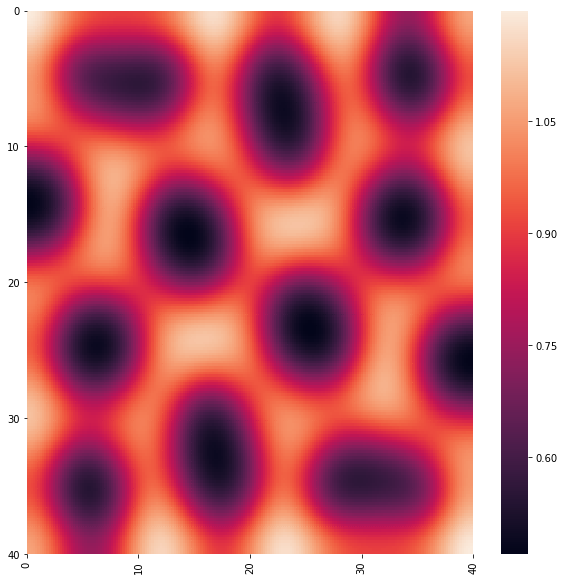

In [6]:
params_system = {'p':2,'q':1.1,'Du':12,'Dv':1,'init_picks':10}
params_numerical = {'points_count':200,'dx':0.2,'dy':0.2,'dt':0.02,'t_calc_batch':0.2,'iters':2500}
Run(params_system, params_numerical)

In [7]:
res[-1]

NameError: name 'res' is not defined